<a href="https://colab.research.google.com/github/suraj93/Intro-to-Quant-Modelling-CFA-2025/blob/main/Section2_Portfolio_Factor_Attribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 2: Factor Attribution - The Truth About Your Returns

## Learning Objectives
1. Decompose portfolio returns into systematic factors vs alpha
2. Identify "closet indexing" using R² analysis
3. Diagnose multicollinearity and its impact on factor models
4. Test model robustness through out-of-sample validation
5. Understand regime dependency in factor exposures

## Key Questions We'll Answer
- **Is your 17% return skill or just factor exposure?**
- **Can you replicate performance with passive index funds?**
- **Does your alpha work in bear markets?**
- **Will your model work next year?**

---
## Cell 1: Setup & Portfolio Construction

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


In [ ]:
# Load data - MODIFY THIS PATH based on your Google Drive structure
# If using Google Colab, uncomment the following:
from google.colab import drive
drive.mount('/content/gdrive')
FILE_PATH = '/content/gdrive/My Drive/Finance AI/2025 CFA Quant workshop/data/india_market_data.csv'

# For local testing, use:
# FILE_PATH = 'india_market_data.csv'  # Update this path

# Load price data
df = pd.read_csv(FILE_PATH)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values('Date').reset_index(drop=True)

# Filter to our analysis period: 2017-2025
df = df[(df['Date'] >= '2017-01-01') & (df['Date'] <= '2025-11-23')].copy()

print(f"Data loaded: {len(df)} days from {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"\nAvailable columns: {list(df.columns)}")

# Show first few rows
df.head(3)

Mounted at /content/gdrive
Data loaded: 2198 days from 2017-01-02 to 2025-11-21

Available columns: ['Date', 'NIFTYBEES', 'JUNIORBEES', 'BANKBEES', 'GOLDBEES', 'LIQUIDBEES', 'NIFTY50', 'NIFTY_BANK', 'NIFTY_MIDCAP', 'GSEC10YR', 'NIFTY_FMCG', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14']


,Date,NIFTYBEES,JUNIORBEES,BANKBEES,GOLDBEES,LIQUIDBEES,NIFTY50,NIFTY_BANK,NIFTY_MIDCAP,GSEC10YR,NIFTY_FMCG,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
1725,2017-01-02,83.51,218.61,181.56,25.58,721.31,8179.50,18176.99,3662.11,196.16,20710.35,NaN,NaN,NaN,NaN
1726,2017-01-03,83.61,219.49,181.88,25.46,721.32,8192.25,18035.39,3718.80,195.81,20864.15,NaN,NaN,NaN,NaN
1727,2017-01-04,83.58,219.54,181.10,25.83,721.31,8190.50,17890.79,3720.55,196.40,20935.25,NaN,NaN,NaN,NaN


In [ ]:
 # Calculate daily returns for all assets
assets = ['NIFTYBEES', 'JUNIORBEES', 'BANKBEES', 'GOLDBEES', 'LIQUIDBEES',
          'NIFTY50', 'NIFTY_BANK', 'NIFTY_MIDCAP', 'GSEC10YR']

returns_df = df[['Date']].copy()
for asset in assets:
    returns_df[asset] = df[asset].pct_change()

# Remove first row (NaN from pct_change)
returns_df = returns_df.iloc[1:].reset_index(drop=True)

print(f"✓ Returns calculated: {len(returns_df)} days")
print(f"\nReturn statistics (daily):")
returns_df[assets].describe().loc[['mean', 'std', 'min', 'max']]

✓ Returns calculated: 2197 days

Return statistics (daily):


,NIFTYBEES,JUNIORBEES,BANKBEES,GOLDBEES,LIQUIDBEES,NIFTY50,NIFTY_BANK,NIFTY_MIDCAP,GSEC10YR
mean,6.17e-04,6.11e-04,6.37e-04,6.65e-04,1.49e-04,5.82e-04,6.31e-04,7.91e-04,2.35e-04
std,9.29e-03,1.06e-02,1.32e-02,8.42e-03,6.95e-04,1.03e-02,1.38e-02,1.31e-02,3.17e-03
min,-1.02e-01,-9.26e-02,-1.44e-01,-4.04e-02,-8.79e-04,-1.30e-01,-1.67e-01,-1.49e-01,-9.23e-03
max,6.72e-02,6.00e-02,9.89e-02,4.78e-02,5.32e-03,8.76e-02,1.05e-01,6.44e-02,1.25e-02


In [ ]:
# Define four portfolios with their allocations

# Portfolio 1: RETAIL - Equal-weighted (naive diversification)
portfolio_weights = {
    'Retail': {
        'NIFTYBEES': 0.2,
        'JUNIORBEES': 0.2,
        'BANKBEES': 0.2,
        'GOLDBEES': 0.2,
        'LIQUIDBEES': 0.2,
    },

    # Portfolio 2: SMART BETA - Factor tilt (size and sector)
    'Smart_Beta': {
        'NIFTYBEES': 0.15,
        'JUNIORBEES': 0.35,
        'BANKBEES': 0.35,
        'GOLDBEES': 0.15,
        'LIQUIDBEES': 0.05
    },

    # Portfolio 3: ACTIVE-BANKING - Sector overweight
    'Active_Banking': {
        'BANKBEES': 0.60,
        'NIFTYBEES': 0.20,
        'JUNIORBEES': 0.10,
        'GOLDBEES': 0.10
    },

    # Portfolio 4: ACTIVE-MIDCAP - Size concentration
    'Active_MidCap': {
        'NIFTY_MIDCAP': 0.60,
        'NIFTYBEES': 0.25,
        'BANKBEES': 0.05,
        'GOLDBEES': 0.10
    }
}

# Display weights as DataFrame
weights_df = pd.DataFrame(portfolio_weights).fillna(0)
print("Portfolio Allocations:")
print(weights_df.style.format("{:.1%}"))

# Show as percentages
weights_df

Portfolio Allocations:


,Retail,Smart_Beta,Active_Banking,Active_MidCap
NIFTYBEES,0.2,0.15,0.2,0.25
JUNIORBEES,0.2,0.35,0.1,0.00
BANKBEES,0.2,0.35,0.6,0.05
GOLDBEES,0.2,0.15,0.1,0.10
LIQUIDBEES,0.2,0.05,0.0,0.00
NIFTY_MIDCAP,0.0,0.00,0.0,0.60


In [ ]:
# Calculate portfolio returns
# For Retail and Smart Beta: Buy-and-hold with annual rebalancing
# For Active portfolios: Monthly rebalancing

def calculate_portfolio_returns(returns_df, weights, rebalance_freq='annual'):
    """
    Calculate portfolio returns with proper cumulative tracking and rebalancing.

    Parameters:
    -----------
    returns_df : DataFrame with Date and asset returns
    weights : dict of {asset: weight}
    rebalance_freq : 'monthly', 'annual', or 'none' (buy-and-hold)

    Returns:
    --------
    List of daily portfolio returns
    """
    # Initialize: Start with $1, allocated according to weights
    asset_values = {asset: weight for asset, weight in weights.items()}
    portfolio_value = 1.0  # Total portfolio starts at $1

    portfolio_returns = []

    # Track rebalancing periods
    df = returns_df.copy()
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.to_period('M')

    prev_year = None
    prev_month = None

    for idx, row in df.iterrows():
        # Step 1: Grow each asset by its daily return
        for asset in weights.keys():
            if asset in row and not pd.isna(row[asset]):
                asset_values[asset] *= (1 + row[asset])

        # Step 2: Calculate new portfolio value
        new_portfolio_value = sum(asset_values.values())

        # Step 3: Calculate portfolio return for this day
        portfolio_return = (new_portfolio_value / portfolio_value) - 1
        portfolio_returns.append(portfolio_return)

        # Step 4: Update portfolio value
        portfolio_value = new_portfolio_value

        # Step 5: Check if rebalancing is needed
        should_rebalance = False

        if rebalance_freq == 'monthly':
            if prev_month is not None and row['month'] != prev_month:
                should_rebalance = True
            prev_month = row['month']

        elif rebalance_freq == 'annual':
            if prev_year is not None and row['year'] != prev_year:
                should_rebalance = True
            prev_year = row['year']

        # Step 6: Rebalance if needed
        if should_rebalance:
            # Redistribute total portfolio value according to target weights
            for asset, target_weight in weights.items():
                asset_values[asset] = portfolio_value * target_weight

    return portfolio_returns

# Calculate returns for all portfolios
returns_df['Retail'] = calculate_portfolio_returns(
    returns_df, portfolio_weights['Retail'], 'annual'
)

returns_df['Smart_Beta'] = calculate_portfolio_returns(
    returns_df, portfolio_weights['Smart_Beta'], 'annual'
)

returns_df['Active_Banking'] = calculate_portfolio_returns(
    returns_df, portfolio_weights['Active_Banking'], 'monthly'
)

returns_df['Active_MidCap'] = calculate_portfolio_returns(
    returns_df, portfolio_weights['Active_MidCap'], 'monthly'
)

print("✓ Portfolio returns calculated")
print("\nFirst 5 days of portfolio returns:")
returns_df[['Date', 'Retail', 'Smart_Beta', 'Active_Banking', 'Active_MidCap']].head()

✓ Portfolio returns calculated

First 5 days of portfolio returns:


,Date,Retail,Smart_Beta,Active_Banking,Active_MidCap
0,2017-01-03,4.44e-04,5.15e-02,1.22e-03,9.20e-03
1,2017-01-04,2.01e-03,6.69e-04,-1.16e-03,1.41e-03
2,2017-01-05,6.34e-03,7.61e-03,8.65e-03,1.29e-02
3,2017-01-06,3.29e-03,5.83e-03,8.71e-03,-1.73e-03
4,2017-01-09,9.25e-04,1.32e-03,1.04e-03,2.14e-03


---
## Cell 2: Performance Scorecard - How Good Are These Portfolios?

In [ ]:
# Calculate comprehensive performance metrics

def calculate_metrics(returns, rfr=0.065):
    """
    Calculate annualized performance metrics.

    Parameters:
    -----------
    returns : Series of daily returns
    rfr : Risk-free rate (annualized)
    """
    # Annualized return
    total_return = (1 + returns).prod() - 1
    n_years = len(returns) / 252
    ann_return = (1 + total_return) ** (1/n_years) - 1

    # Annualized volatility
    ann_vol = returns.std() * np.sqrt(252)

    # Sharpe ratio
    sharpe = (ann_return - rfr) / ann_vol

    # Maximum drawdown
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.expanding().max()
    drawdown = (cum_returns - running_max) / running_max
    max_dd = drawdown.min()

    # Calmar ratio
    calmar = ann_return / abs(max_dd) if max_dd != 0 else 0

    # Sortino ratio (downside deviation)
    downside_returns = returns[returns < 0]
    downside_std = downside_returns.std() * np.sqrt(252)
    sortino = (ann_return - rfr) / downside_std if downside_std > 0 else 0

    return {
        'Return': ann_return,
        'Volatility': ann_vol,
        'Sharpe': sharpe,
        'Max_DD': max_dd,
        'Calmar': calmar,
        'Sortino': sortino
    }

# Calculate for all portfolios
portfolios = ['Retail', 'Smart_Beta', 'Active_Banking', 'Active_MidCap']
metrics = {}

for portfolio in portfolios:
    metrics[portfolio] = calculate_metrics(returns_df[portfolio])

# Create performance table
performance_df = pd.DataFrame(metrics).T

print("="*80)
print("PERFORMANCE SCORECARD (2017-2025)")
print("="*80)
print(performance_df.style.format({
    'Return': '{:.1%}',
    'Volatility': '{:.1%}',
    'Sharpe': '{:.2f}',
    'Max_DD': '{:.1%}',
    'Calmar': '{:.2f}',
    'Sortino': '{:.2f}'
}))

performance_df

PERFORMANCE SCORECARD (2017-2025)


,Return,Volatility,Sharpe,Max_DD,Calmar,Sortino
Retail,0.14,0.09,0.77,-0.23,0.60,0.97
Smart_Beta,0.21,0.14,1.05,-0.32,0.67,1.40
Active_Banking,0.16,0.16,0.57,-0.39,0.40,0.71
Active_MidCap,0.19,0.16,0.73,-0.37,0.50,0.87


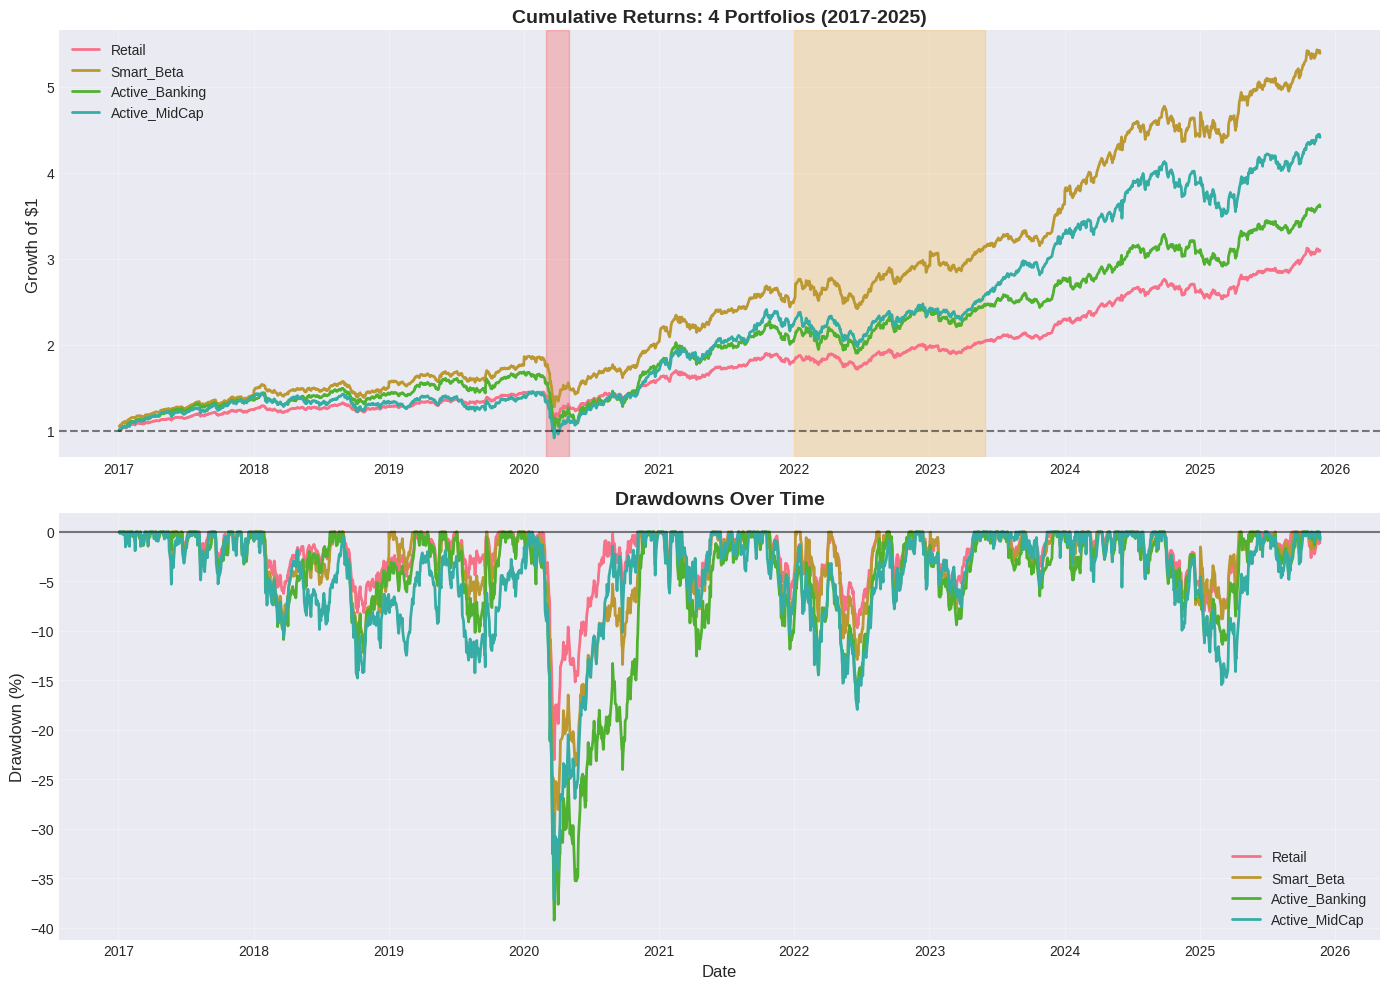


📊 Key Observations:
1. Active-Banking: Highest return but also deepest drawdown
2. Smart Beta: Consistent outperformance vs Retail
3. All portfolios suffered in COVID and 2022 rate hike periods
4. Active-MidCap: Best risk-adjusted profile (high return, moderate DD)


In [ ]:
# Visualize: Cumulative returns over time

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Panel 1: Cumulative returns
for portfolio in portfolios:
    cum_returns = (1 + returns_df[portfolio]).cumprod()
    axes[0].plot(returns_df['Date'], cum_returns, label=portfolio, linewidth=2)

axes[0].set_title('Cumulative Returns: 4 Portfolios (2017-2025)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Growth of $1', fontsize=12)
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=1, color='black', linestyle='--', alpha=0.5)

# Shade crisis periods
axes[0].axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2020-05-01'),
                alpha=0.2, color='red', label='COVID Crisis')
axes[0].axvspan(pd.Timestamp('2022-01-01'), pd.Timestamp('2023-06-01'),
                alpha=0.2, color='orange', label='Rate Hike Period')

# Panel 2: Drawdowns
for portfolio in portfolios:
    cum_returns = (1 + returns_df[portfolio]).cumprod()
    running_max = cum_returns.expanding().max()
    drawdown = (cum_returns - running_max) / running_max
    axes[1].plot(returns_df['Date'], drawdown * 100, label=portfolio, linewidth=2)

axes[1].set_title('Drawdowns Over Time', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Drawdown (%)', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].legend(loc='lower right', fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

print("\n📊 Key Observations:")
print("1. Active-Banking: Highest return but also deepest drawdown")
print("2. Smart Beta: Consistent outperformance vs Retail")
print("3. All portfolios suffered in COVID and 2022 rate hike periods")
print("4. Active-MidCap: Best risk-adjusted profile (high return, moderate DD)")

---
## Cell 3: Correlation Heatmap - Understanding Factor Exposures

In [ ]:
# Create orthogonal factors (excess returns approach)
# This removes multicollinearity issues

returns_df['Market_Factor'] = returns_df['NIFTY50']
returns_df['Size_Factor'] = returns_df['NIFTY_MIDCAP'] - returns_df['NIFTY50']  # Small minus Large
returns_df['Bank_Factor'] = returns_df['NIFTY_BANK'] - returns_df['NIFTY50']   # Sector tilt
returns_df['Bond_Factor'] = returns_df['GSEC10YR']
returns_df['Gold_Factor'] = returns_df['GOLDBEES']

print("✓ Orthogonal factors created:")
print("  - Market_Factor: Overall equity risk premium (NIFTY50)")
print("  - Size_Factor: Small cap premium (MidCap - Nifty50)")
print("  - Bank_Factor: Banking sector tilt (Bank - Nifty50)")
print("  - Bond_Factor: Fixed income exposure")
print("  - Gold_Factor: Commodity/inflation hedge")

# Calculate correlation matrix
factors = ['Market_Factor', 'Size_Factor', 'Bank_Factor', 'Bond_Factor', 'Gold_Factor']
corr_data = returns_df[portfolios + factors]
corr_matrix = corr_data.corr()

# Extract portfolio vs factor correlations
portfolio_factor_corr = corr_matrix.loc[portfolios, factors]

print("\nPortfolio-Factor Correlations:")
portfolio_factor_corr

✓ Orthogonal factors created:
  - Market_Factor: Overall equity risk premium (NIFTY50)
  - Size_Factor: Small cap premium (MidCap - Nifty50)
  - Bank_Factor: Banking sector tilt (Bank - Nifty50)
  - Bond_Factor: Fixed income exposure
  - Gold_Factor: Commodity/inflation hedge

Portfolio-Factor Correlations:


,Market_Factor,Size_Factor,Bank_Factor,Bond_Factor,Gold_Factor
Retail,0.88,0.23,0.38,-5.73e-03,0.26
Smart_Beta,0.84,0.25,0.40,2.54e-03,0.11
Active_Banking,0.91,0.13,0.59,-3.73e-03,0.03
Active_MidCap,0.90,0.50,0.30,-1.56e-02,0.04


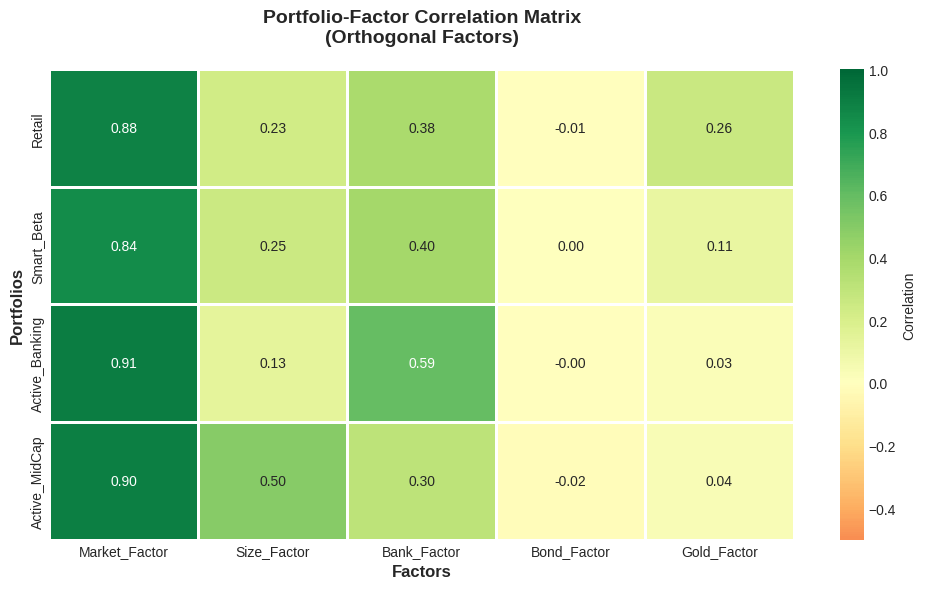


🔍 Key Insights:
RETAIL:
  - Market correlation: 0.88
  - Interpretation: Very high market beta, essentially buying the index

SMART BETA:
  - Size factor: 0.25
  - Bank factor: 0.40
  - Interpretation: Diversified factor exposure, not just market

ACTIVE-BANKING:
  - Bank factor: 0.59
  - Interpretation: Concentrated bet on banking sector - high single-factor risk!

ACTIVE-MIDCAP:
  - Size factor: 0.50
  - Interpretation: Strong mid-cap exposure, differentiated from large cap


In [ ]:
# Visualize correlation heatmap

fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(portfolio_factor_corr, annot=True, fmt='.2f', cmap='RdYlGn',
            center=0, vmin=-0.5, vmax=1.0,
            cbar_kws={'label': 'Correlation'},
            linewidths=1, linecolor='white',
            ax=ax)

ax.set_title('Portfolio-Factor Correlation Matrix\n(Orthogonal Factors)',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Factors', fontsize=12, fontweight='bold')
ax.set_ylabel('Portfolios', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n🔍 Key Insights:")
print("="*70)
print("RETAIL:")
print(f"  - Market correlation: {portfolio_factor_corr.loc['Retail', 'Market_Factor']:.2f}")
print("  - Interpretation: Very high market beta, essentially buying the index")
print("\nSMART BETA:")
print(f"  - Size factor: {portfolio_factor_corr.loc['Smart_Beta', 'Size_Factor']:.2f}")
print(f"  - Bank factor: {portfolio_factor_corr.loc['Smart_Beta', 'Bank_Factor']:.2f}")
print("  - Interpretation: Diversified factor exposure, not just market")
print("\nACTIVE-BANKING:")
print(f"  - Bank factor: {portfolio_factor_corr.loc['Active_Banking', 'Bank_Factor']:.2f}")
print("  - Interpretation: Concentrated bet on banking sector - high single-factor risk!")
print("\nACTIVE-MIDCAP:")
print(f"  - Size factor: {portfolio_factor_corr.loc['Active_MidCap', 'Size_Factor']:.2f}")
print("  - Interpretation: Strong mid-cap exposure, differentiated from large cap")

---
## Cell 4: EXERCISE 1 - "Am I Just Buying the Index?"
### Goal: Strip away systematic factor exposures to find true alpha
### Question: How is your portfolio generating returns? Alpha from picking, or just repackaging indices?

In [ ]:
# ============================================================================
# PART A: PORTFOLIO PERFORMANCE SUMMARY
# ============================================================================

print("\n" + "="*100)
print("PORTFOLIO PERFORMANCE SUMMARY (2017-2025)")
print("="*100)

summary_data = []
for portfolio in portfolios:
    summary_data.append({
        'Portfolio': portfolio,
        'Total Return': f"{performance_df.loc[portfolio, 'Return']:.1%}",
        'Sharpe Ratio': f"{performance_df.loc[portfolio, 'Sharpe']:.2f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))


PORTFOLIO PERFORMANCE SUMMARY (2017-2025)

     Portfolio Total Return Sharpe Ratio
        Retail        13.8%         0.77
    Smart_Beta        21.3%         1.05
Active_Banking        15.8%         0.57
 Active_MidCap        18.6%         0.73


In [ ]:
# ============================================================================
# PART B: PROGRESSIVE FACTOR MODELS
# ============================================================================

print("\n\n" + "="*100)
print("PROGRESSIVE FACTOR MODELS: WATCH ALPHA SHRINK")
print("="*100)
print("""
Model 1: Portfolio ~ Market
Model 2: Portfolio ~ Market + Size
Model 3: Portfolio ~ Market + Size + Bank

As we add factors, we control for more systematic exposures.
What remains is TRUE alpha (or noise).
""")
'''
# Run regressions (keep existing code from before)
def run_factor_regression(returns, factors_list, factor_data):
    """Run OLS regression and return results"""
    y = returns.values
    X = factor_data[factors_list].values
    X = sm.add_constant(X)

    model = sm.OLS(y, X, missing='drop').fit()

    alpha = model.params[0] * 252 * 100  # Annualized in bps
    betas = dict(zip(factors_list, model.params[1:]))
    alpha_tstat = model.tvalues[0]
    r_squared = model.rsquared

    return {
        'R²': r_squared,
        'Alpha_bps': alpha,
        'Alpha_tstat': alpha_tstat,
        'Betas': betas,
        'Model': model
    }
'''
def run_factor_regression(returns, factors_list, factor_data):
    """Run OLS regression and return results with proper index tracking"""

    # Create DataFrame to ensure index alignment
    df = pd.DataFrame({
        'y': returns,
        **{f: factor_data[f] for f in factors_list}
    }).dropna()  # Drop rows with any NaN values

    # Now we have clean data with preserved index
    y = df['y'].values
    X = df[factors_list].values
    X = sm.add_constant(X)

    # Run regression
    model = sm.OLS(y, X).fit()

    # Calculate alpha
    alpha_daily = model.params[0]
    alpha_annual_bps = alpha_daily * 252 * 100 * 100  # Convert to bps
    alpha_monthly_bps = alpha_annual_bps / 12

    betas = dict(zip(factors_list, model.params[1:]))
    alpha_tstat = model.tvalues[0]
    r_squared = model.rsquared

    # Store the cleaned index for later use
    valid_indices = df.index

    return {
        'R²': r_squared,
        'Alpha_bps_annual': alpha_annual_bps,
        'Alpha_bps_monthly': alpha_monthly_bps,
        'Alpha_tstat': alpha_tstat,
        'Betas': betas,
        'Model': model,
        'Valid_Indices': valid_indices,  # ← NEW: Track which rows were used
        'Clean_Data': df  # ← NEW: Store the cleaned data
    }

# Define three models
models_spec = {
    'Model_1': ['Market_Factor'],
    'Model_2': ['Market_Factor', 'Size_Factor'],
    'Model_3': ['Market_Factor', 'Size_Factor', 'Bank_Factor']
}

# Run regressions for all portfolios
results = {}
for portfolio in portfolios:
    results[portfolio] = {}
    for model_name, factors_list in models_spec.items():
        results[portfolio][model_name] = run_factor_regression(
            returns_df[portfolio],
            factors_list,
            returns_df
        )

# Create enhanced results table
results_enhanced = []

for portfolio in portfolios:
    total_return = performance_df.loc[portfolio, 'Return']

    for model_name in ['Model_1', 'Model_2', 'Model_3']:
        res = results[portfolio][model_name]

        # Calculate % of return from beta (factors)
        fitted_returns = res['Model'].fittedvalues
        fitted_return_annual = fitted_returns.mean() * 252
        pct_from_beta = (fitted_return_annual / total_return * 100) if total_return != 0 else 0

        # Classify based on R²
        r2 = res['R²']
        if r2 > 0.85:
            classification = "Index-Like"
        elif r2 >= 0.70:
            classification = "Factor Tilt"
        else:
            classification = "Active Strategy"

        results_enhanced.append({
            'Portfolio': portfolio,
            'Model': model_name.replace('Model_', 'M'),
            'R²': res['R²'],
            'Alpha (bps/mo)': res['Alpha_bps_monthly'],
            't-stat': res['Alpha_tstat'],
            '% from Beta': pct_from_beta,
            'Classification': classification,
            'Valid_Indices': res['Valid_Indices'],  # ← NEW: Track which rows were used
            'Clean_Data': res['Clean_Data']  # ← NEW: Store the cleaned data
        })

results_enhanced_df = pd.DataFrame(results_enhanced)

# Display results by portfolio
print("\n" + "="*100)
print("REGRESSION RESULTS")
print("="*100)

for portfolio in portfolios:
    print(f"\n{portfolio.upper()}")
    print("-" * 100)
    portfolio_results = results_enhanced_df[results_enhanced_df['Portfolio'] == portfolio]

    for idx, row in portfolio_results.iterrows():
        print(f"{row['Model']:8} | R²={row['R²']:5.1%} | "
              f"Alpha={row['Alpha (bps/mo)']:6.1f} bps/mo | "
              f"t-stat={row['t-stat']:5.2f} | "
              f"{row['% from Beta']:5.0f}% from Beta | "
              f"{row['Classification']}")



PROGRESSIVE FACTOR MODELS: WATCH ALPHA SHRINK

Model 1: Portfolio ~ Market
Model 2: Portfolio ~ Market + Size
Model 3: Portfolio ~ Market + Size + Bank

As we add factors, we control for more systematic exposures.
What remains is TRUE alpha (or noise).


REGRESSION RESULTS

RETAIL
----------------------------------------------------------------------------------------------------
M1       | R²=78.2% | Alpha=  49.1 bps/mo | t-stat= 3.91 |    97% from Beta | Factor Tilt
M2       | R²=80.8% | Alpha=  44.1 bps/mo | t-stat= 3.75 |    97% from Beta | Factor Tilt
M3       | R²=82.5% | Alpha=  45.7 bps/mo | t-stat= 4.06 |    97% from Beta | Factor Tilt

SMART_BETA
----------------------------------------------------------------------------------------------------
M1       | R²=71.1% | Alpha=  81.1 bps/mo | t-stat= 3.80 |    95% from Beta | Factor Tilt
M2       | R²=74.8% | Alpha=  72.4 bps/mo | t-stat= 3.63 |    95% from Beta | Factor Tilt
M3       | R²=77.1% | Alpha=  75.4 bps/mo | t-stat= 



VISUAL BREAKDOWN: WHERE DO RETURNS REALLY COME FROM?

Focus Portfolio: Active_MidCap
Total Annual Return: 18.4%

Factor Exposures (Betas):
  Market_Factor        Beta =  0.86 × Factor Return =  14.7% → Contribution =  12.6%
  Size_Factor          Beta =  0.61 × Factor Return =   5.3% → Contribution =   3.2%
  Bank_Factor          Beta =  0.04 × Factor Return =   1.2% → Contribution =   0.1%

Return Decomposition:
  Intercept (α):              2.6%
  Market Factor:             12.6%
  Size Factor:                3.2%
  Bank Factor:                0.1%
  ────────────────────────────────────────
  Sum of components:         18.4%
  Actual return:             18.4%
  Difference:                0.00%
  ✓ Waterfall verified

🎯 Key Insight:
   14% of return (2.6%) is the intercept (α)
   86% of return comes from systematic factor exposures


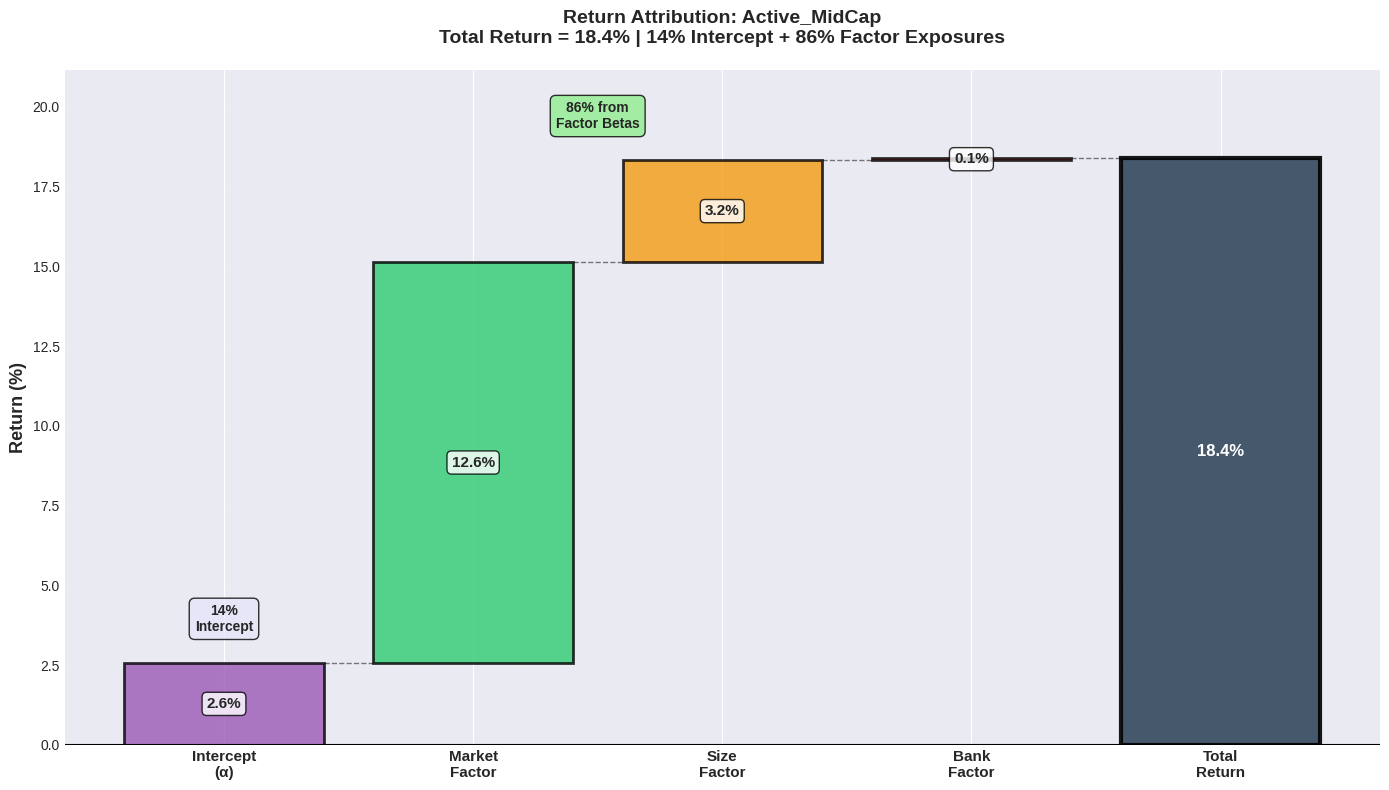

In [ ]:
# ============================================================================
# PART D: WATERFALL VISUALIZATION - WHERE RETURNS COME FROM
# ============================================================================

print("\n\n" + "="*100)
print("VISUAL BREAKDOWN: WHERE DO RETURNS REALLY COME FROM?")
print("="*100)

# Focus on Active_MidCap (or choose the most interesting portfolio)
focus_portfolio = 'Active_MidCap'
model_results = results[focus_portfolio]['Model_3']
model = model_results['Model']
valid_indices = model_results['Valid_Indices']

# Portfolio returns (using SAME sample as regression)
portfolio_returns_in_sample = returns_df.loc[valid_indices, focus_portfolio]
actual_return = portfolio_returns_in_sample.mean() * 252

print(f"\nFocus Portfolio: {focus_portfolio}")
print(f"Total Annual Return: {actual_return:.1%}")
print(f"\nFactor Exposures (Betas):")

# Calculate factor contributions using IN-SAMPLE means
factor_list = ['Market_Factor', 'Size_Factor', 'Bank_Factor']
factor_contributions = {}

for i, factor in enumerate(factor_list):
    beta = model.params[i+1]
    # CRITICAL: Use same sample as regression
    factor_return = returns_df.loc[valid_indices, factor].mean() * 252
    contribution = beta * factor_return
    factor_contributions[factor] = contribution
    print(f"  {factor:20} Beta = {beta:5.2f} × Factor Return = {factor_return:6.1%} → Contribution = {contribution:6.1%}")

# Intercept (NOT pure alpha - includes gold, rebalancing, etc.)
intercept = model.params[0] * 252

print(f"\nReturn Decomposition:")
print(f"  Intercept (α):            {intercept:6.1%}")
print(f"  Market Factor:            {factor_contributions['Market_Factor']:6.1%}")
print(f"  Size Factor:              {factor_contributions['Size_Factor']:6.1%}")
print(f"  Bank Factor:              {factor_contributions['Bank_Factor']:6.1%}")
print(f"  {'─' * 40}")

# Verify sum
calculated_total = intercept + sum(factor_contributions.values())
print(f"  Sum of components:        {calculated_total:6.1%}")
print(f"  Actual return:            {actual_return:6.1%}")
print(f"  Difference:               {abs(actual_return - calculated_total):6.2%}")

if abs(actual_return - calculated_total) > 0.1:
    print(f"  ⚠️  WARNING: Waterfall doesn't sum correctly!")
else:
    print(f"  ✓ Waterfall verified")

pct_from_intercept = (intercept / actual_return) * 100
pct_from_factors = (sum(factor_contributions.values()) / actual_return) * 100

print(f"\n🎯 Key Insight:")
print(f"   {pct_from_intercept:.0f}% of return ({intercept:.1%}) is the intercept (α)")
print(f"   {pct_from_factors:.0f}% of return comes from systematic factor exposures")

# Create waterfall chart
fig, ax = plt.subplots(figsize=(14, 8))

# Prepare waterfall data (NO RISK-FREE RATE)
categories = ['Intercept\n(α)', 'Market\nFactor', 'Size\nFactor',
              'Bank\nFactor', 'Total\nReturn']

values = [
    intercept * 100,
    factor_contributions['Market_Factor'] * 100,
    factor_contributions['Size_Factor'] * 100,
    factor_contributions['Bank_Factor'] * 100,
    0  # Placeholder for total
]

# Calculate cumulative for waterfall
cumulative = [0]
for i, val in enumerate(values[:-1]):
    cumulative.append(cumulative[-1] + val)

# Color scheme
colors = ['#9b59b6', '#2ecc71', '#f39c12', '#e74c3c', '#34495e']

# Draw component bars
for i in range(len(values) - 1):
    ax.bar(i, values[i], bottom=cumulative[i],
           color=colors[i], edgecolor='black', linewidth=2, alpha=0.8)

    # Add value labels
    label_y = cumulative[i] + values[i] / 2
    ax.text(i, label_y, f'{values[i]:.1f}%',
            ha='center', va='center', fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Draw total bar
total_bar_value = actual_return * 100
ax.bar(len(values) - 1, total_bar_value,
       color=colors[-1], edgecolor='black', linewidth=3, alpha=0.9)
ax.text(len(values) - 1, total_bar_value / 2, f'{total_bar_value:.1f}%',
        ha='center', va='center', fontsize=12, fontweight='bold', color='white')

# Draw connector lines
for i in range(len(cumulative) - 1):
    ax.plot([i + 0.4, i + 1 - 0.4], [cumulative[i + 1], cumulative[i + 1]],
            'k--', linewidth=1, alpha=0.5)

# Formatting
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, fontsize=11, fontweight='bold')
ax.set_ylabel('Return (%)', fontsize=13, fontweight='bold')
ax.set_title(f'Return Attribution: {focus_portfolio}\n' +
             f'Total Return = {actual_return:.1%} | {pct_from_intercept:.0f}% Intercept + {pct_from_factors:.0f}% Factor Exposures',
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle=':')
ax.axhline(y=0, color='black', linewidth=1.5)
ax.set_ylim(0, total_bar_value * 1.15)

# Add annotation boxes
ax.text(0, cumulative[1] + 1,
        f'{pct_from_intercept:.0f}%\nIntercept',
        ha='center', fontsize=10, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='lavender', alpha=0.8))

ax.text(1.5, cumulative[3] + 1,
        f'{pct_from_factors:.0f}% from\nFactor Betas',
        ha='center', fontsize=10, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# PART F: CLASSIFICATION FRAMEWORK
# ============================================================================

print("\n" + "="*100)
print("CLASSIFICATION FRAMEWORK")
print("="*100)
print("""
Based on R² from Model 3 (Market + Size + Bank):

┌─────────────┬──────────────────────────────────────────────────────────┐
│ R² Range    │ Classification & Interpretation                          │
├─────────────┼──────────────────────────────────────────────────────────┤
│ R² > 85%    │ INDEX-LIKE                                               │
│             │ • Most returns explained by common factors               │
│             │ • Minimal differentiation                                │
│             │ • Question: Why pay active fees?                         │
├─────────────┼──────────────────────────────────────────────────────────┤
│ R² 70-85%   │ FACTOR TILT                                              │
│             │ • Systematic exposures with some differentiation         │
│             │ • 15-30% unique component                                │
│             │ • Could be: smart beta, sector tilts, style factors      │
├─────────────┼──────────────────────────────────────────────────────────┤
│ R² < 70%    │ ACTIVE STRATEGY                                          │
│             │ • Significant unexplained variance                       │
│             │ • Could be: skill, alternative factors, or higher risk   │
│             │ • Requires investigation of intercept sources            │
└─────────────┴──────────────────────────────────────────────────────────┘

Remember: Low R² ≠ High Alpha
• R² measures VARIANCE explained (volatility)
• Intercept measures MEAN excess return
• Can have low R² (e.g., from gold) with low intercept (gold return ≈ equity)
""")


CLASSIFICATION FRAMEWORK

Based on R² from Model 3 (Market + Size + Bank):

┌─────────────┬──────────────────────────────────────────────────────────┐
│ R² Range    │ Classification & Interpretation                          │
├─────────────┼──────────────────────────────────────────────────────────┤
│ R² > 85%    │ INDEX-LIKE                                               │
│             │ • Most returns explained by common factors               │
│             │ • Minimal differentiation                                │
│             │ • Question: Why pay active fees?                         │
├─────────────┼──────────────────────────────────────────────────────────┤
│ R² 70-85%   │ FACTOR TILT                                              │
│             │ • Systematic exposures with some differentiation         │
│             │ • 15-30% unique component                                │
│             │ • Could be: smart beta, sector tilts, style factors      │
├─────────────┼────────

# Section 5: Out Sample Validation

### Objective: run train and test on different time frames, to monitor model performance

CELL 9: OUT-OF-SAMPLE VALIDATION - OVERFITTING WARNING

Critical Question: Will this model work next year, or is it overfit to history?

Test: Train model on 2017-2023, apply to 2024-2025 (new data)


DATA SPLIT

Training Period:  2017-01-03 to 2023-12-29
                  1728 trading days (~6.9 years)

Test Period:      2024-01-01 to 2025-11-21
                  469 trading days (~1.9 years)

💡 Key Principle: Train on OLD data, test on NEW data
   Use the SAME betas from training - do NOT re-estimate on test data!

TRAINING MODELS (2017-2023)

Retail:
  R² (in-sample): 86.0%
  Alpha (in-sample): 4 bps/year

Smart_Beta:
  R² (in-sample): 80.1%
  Alpha (in-sample): 8 bps/year

Active_Banking:
  R² (in-sample): 96.7%
  Alpha (in-sample): 3 bps/year

Active_MidCap:
  R² (in-sample): 99.1%
  Alpha (in-sample): 2 bps/year


TESTING MODELS (2024-2025)

Applying trained betas to NEW data (no re-estimation)...

Retail:
  R² (out-of-sample): 65.3%
  Alpha (out-of-sample): 6 bps/year

Smart_Bet

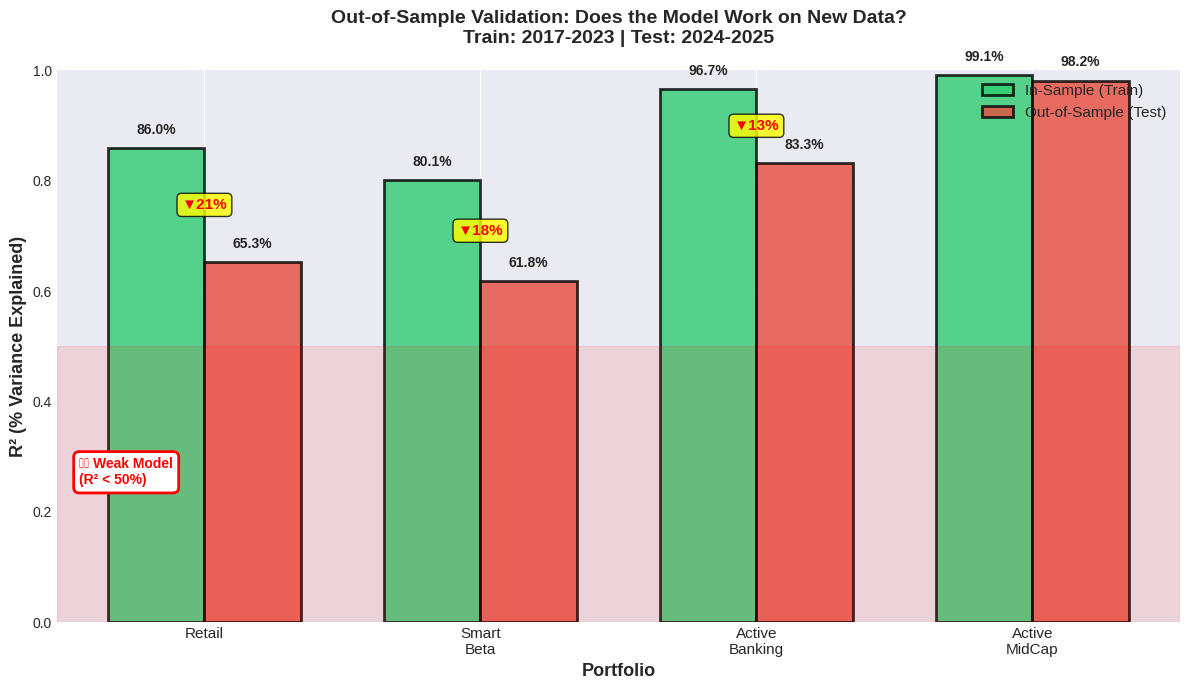


INTERPRETATION

R² DEGRADATION GUIDE:

Drop < 10%:  ✓ STABLE - Model is reliable, factor relationships consistent
Drop 10-20%: ~ CAUTION - Some overfitting or regime change
Drop > 20%:  ✗ OVERFIT - Model fit noise, not signal. Do NOT trust!

WHY MODELS DEGRADE:
• Overfitting: Captured noise in training period
• Regime shift: Factor relationships changed (2024 ≠ 2017-2023)
• Small test sample: 2 years may not be representative


PORTFOLIO-SPECIFIC WARNINGS

Retail:
  Drop: +20.7%
  🚨 WARNING: Severe overfitting detected!
     Model lost 21% explanatory power on new data
     → DO NOT trust betas from 2017-2023 period

Smart_Beta:
  Drop: +18.3%
  ⚠️  CAUTION: Moderate degradation
     → Monitor closely, consider re-estimation

Active_Banking:
  Drop: +13.4%
  ⚠️  CAUTION: Moderate degradation
     → Monitor closely, consider re-estimation

Active_MidCap:
  Drop: +0.9%
  ✓ STABLE: Factor exposures are consistent

CELL 9 COMPLETE: OUT-OF-SAMPLE VALIDATION

✓ Validated models on NEW data 

In [ ]:
# CELL 9: OUT-OF-SAMPLE VALIDATION - OVERFITTING WARNING
# Simple 5-minute test: Does the model work on new data?

print("="*100)
print("CELL 9: OUT-OF-SAMPLE VALIDATION - OVERFITTING WARNING")
print("="*100)
print("""
Critical Question: Will this model work next year, or is it overfit to history?

Test: Train model on 2017-2023, apply to 2024-2025 (new data)
Warning: If R² drops significantly, the model is overfit and unreliable.
""")

# ============================================================================
# STEP 1: SPLIT DATA
# ============================================================================

print("\n" + "="*100)
print("DATA SPLIT")
print("="*100)

# Define split date
split_date = pd.Timestamp('2024-01-01')

# Split data
train_df = returns_df[returns_df['Date'] < split_date].copy()
test_df = returns_df[returns_df['Date'] >= split_date].copy()

print(f"\nTraining Period:  {train_df['Date'].min().strftime('%Y-%m-%d')} to {train_df['Date'].max().strftime('%Y-%m-%d')}")
print(f"                  {len(train_df)} trading days (~{len(train_df)/252:.1f} years)")

print(f"\nTest Period:      {test_df['Date'].min().strftime('%Y-%m-%d')} to {test_df['Date'].max().strftime('%Y-%m-%d')}")
print(f"                  {len(test_df)} trading days (~{len(test_df)/252:.1f} years)")

print("\n💡 Key Principle: Train on OLD data, test on NEW data")
print("   Use the SAME betas from training - do NOT re-estimate on test data!")

# ============================================================================
# STEP 2: TRAIN MODELS (In-Sample)
# ============================================================================

print("\n" + "="*100)
print("TRAINING MODELS (2017-2023)")
print("="*100)

def train_factor_model(portfolio_name, train_data):
    """Train factor model on training data only"""

    # Prepare data
    df = pd.DataFrame({
        'y': train_data[portfolio_name],
        'Market': train_data['Market_Factor'],
        'Size': train_data['Size_Factor'],
        'Bank': train_data['Bank_Factor']
    }).dropna()

    y = df['y'].values
    X = df[['Market', 'Size', 'Bank']].values
    X = sm.add_constant(X)

    # Fit model
    model = sm.OLS(y, X).fit()

    # Calculate in-sample R²
    r2_train = model.rsquared

    # Calculate in-sample alpha (annualized)
    alpha_train = model.params[0] * 252 * 100  # Convert to bps/year

    return {
        'betas': model.params,  # [intercept, beta_market, beta_size, beta_bank]
        'r2_train': r2_train,
        'alpha_train': alpha_train,
        'model': model
    }

# Train models for all portfolios
trained_models = {}

for portfolio in portfolios:
    trained_models[portfolio] = train_factor_model(portfolio, train_df)
    print(f"\n{portfolio}:")
    print(f"  R² (in-sample): {trained_models[portfolio]['r2_train']:.1%}")
    print(f"  Alpha (in-sample): {trained_models[portfolio]['alpha_train']:.0f} bps/year")

# ============================================================================
# STEP 3: TEST MODELS (Out-of-Sample)
# ============================================================================

print("\n\n" + "="*100)
print("TESTING MODELS (2024-2025)")
print("="*100)
print("\nApplying trained betas to NEW data (no re-estimation)...")

def test_factor_model(portfolio_name, test_data, trained_betas):
    """Apply trained model to test data (out-of-sample)"""

    # Prepare test data
    df = pd.DataFrame({
        'y': test_data[portfolio_name],
        'Market': test_data['Market_Factor'],
        'Size': test_data['Size_Factor'],
        'Bank': test_data['Bank_Factor']
    }).dropna()

    y_actual = df['y'].values
    X = df[['Market', 'Size', 'Bank']].values
    X = sm.add_constant(X)

    # Predict using TRAINED betas (critical: don't re-estimate!)
    y_predicted = X @ trained_betas

    # Calculate out-of-sample R²
    residuals = y_actual - y_predicted
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((y_actual - y_actual.mean()) ** 2)
    r2_test = 1 - (ss_res / ss_tot)

    # Calculate out-of-sample alpha
    alpha_test = residuals.mean() * 252 * 100  # Annualized bps

    return {
        'r2_test': r2_test,
        'alpha_test': alpha_test,
        'residuals': residuals
    }

# Test all models
test_results = {}

for portfolio in portfolios:
    test_results[portfolio] = test_factor_model(
        portfolio,
        test_df,
        trained_models[portfolio]['betas']
    )
    print(f"\n{portfolio}:")
    print(f"  R² (out-of-sample): {test_results[portfolio]['r2_test']:.1%}")
    print(f"  Alpha (out-of-sample): {test_results[portfolio]['alpha_test']:.0f} bps/year")

# ============================================================================
# STEP 4: COMPARE IN-SAMPLE VS OUT-OF-SAMPLE
# ============================================================================

print("\n\n" + "="*100)
print("VALIDATION RESULTS: IN-SAMPLE VS OUT-OF-SAMPLE")
print("="*100)

# Build comparison table
comparison_data = []

for portfolio in portfolios:
    r2_train = trained_models[portfolio]['r2_train']
    r2_test = test_results[portfolio]['r2_test']
    r2_drop = r2_train - r2_test

    alpha_train = trained_models[portfolio]['alpha_train']
    alpha_test = test_results[portfolio]['alpha_test']

    # Classify degradation
    if r2_drop < 0:
        verdict = "✓ IMPROVED"
    elif r2_drop < 0.10:
        verdict = "✓ STABLE"
    elif r2_drop < 0.20:
        verdict = "~ MODERATE DECAY"
    else:
        verdict = "✗ OVERFIT"

    comparison_data.append({
        'Portfolio': portfolio,
        'R² Train': r2_train,
        'R² Test': r2_test,
        'R² Drop': r2_drop,
        'Verdict': verdict
    })

comparison_df = pd.DataFrame(comparison_data)

# Display table
print("\n")
for idx, row in comparison_df.iterrows():
    print(f"{row['Portfolio']:20} | Train: {row['R² Train']:5.1%} | "
          f"Test: {row['R² Test']:5.1%} | Drop: {row['R² Drop']:+5.1%} | {row['Verdict']}")

# ============================================================================
# STEP 5: VISUAL COMPARISON
# ============================================================================

print("\n\n" + "="*100)
print("VISUAL: R² DEGRADATION")
print("="*100)

fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(portfolios))
width = 0.35

# Plot bars
train_bars = ax.bar(x - width/2, comparison_df['R² Train'], width,
                     label='In-Sample (Train)', color='#2ecc71',
                     edgecolor='black', linewidth=2, alpha=0.8)

test_bars = ax.bar(x + width/2, comparison_df['R² Test'], width,
                    label='Out-of-Sample (Test)', color='#e74c3c',
                    edgecolor='black', linewidth=2, alpha=0.8)

# Add value labels
for i, (train_val, test_val) in enumerate(zip(comparison_df['R² Train'], comparison_df['R² Test'])):
    ax.text(i - width/2, train_val + 0.02, f'{train_val:.1%}',
           ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax.text(i + width/2, test_val + 0.02, f'{test_val:.1%}',
           ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add drop annotations for significant drops
for i, drop in enumerate(comparison_df['R² Drop']):
    if drop > 0.10:
        mid_y = (comparison_df['R² Train'].iloc[i] + comparison_df['R² Test'].iloc[i])/2
        ax.text(i, mid_y, f'▼{drop:.0%}', ha='center', va='center',
               fontsize=11, fontweight='bold', color='red',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8))

# Formatting
ax.set_xlabel('Portfolio', fontsize=13, fontweight='bold')
ax.set_ylabel('R² (% Variance Explained)', fontsize=13, fontweight='bold')
ax.set_title('Out-of-Sample Validation: Does the Model Work on New Data?\n' +
            'Train: 2017-2023 | Test: 2024-2025',
            fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([p.replace('_', '\n') for p in portfolios], fontsize=11)
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(axis='y', alpha=0.3, linestyle=':')
ax.set_ylim(0, 1.0)

# Add warning zone
ax.axhspan(0, 0.50, alpha=0.1, color='red')
ax.text(0.02, 0.25, '⚠️ Weak Model\n(R² < 50%)',
       transform=ax.transAxes, fontsize=10, fontweight='bold', color='red',
       bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='red', linewidth=2))

plt.tight_layout()
plt.show()

# ============================================================================
# STEP 6: KEY TAKEAWAYS
# ============================================================================

print("\n" + "="*100)
print("INTERPRETATION")
print("="*100)

print("""
R² DEGRADATION GUIDE:

Drop < 10%:  ✓ STABLE - Model is reliable, factor relationships consistent
Drop 10-20%: ~ CAUTION - Some overfitting or regime change
Drop > 20%:  ✗ OVERFIT - Model fit noise, not signal. Do NOT trust!

WHY MODELS DEGRADE:
• Overfitting: Captured noise in training period
• Regime shift: Factor relationships changed (2024 ≠ 2017-2023)
• Small test sample: 2 years may not be representative
""")

print("\n" + "="*100)
print("PORTFOLIO-SPECIFIC WARNINGS")
print("="*100)

for idx, row in comparison_df.iterrows():
    portfolio = row['Portfolio']
    r2_drop = row['R² Drop']

    print(f"\n{portfolio}:")
    print(f"  Drop: {r2_drop:+.1%}")

    if r2_drop > 0.20:
        print(f"  🚨 WARNING: Severe overfitting detected!")
        print(f"     Model lost {r2_drop:.0%} explanatory power on new data")
        print(f"     → DO NOT trust betas from 2017-2023 period")

    elif r2_drop > 0.10:
        print(f"  ⚠️  CAUTION: Moderate degradation")
        print(f"     → Monitor closely, consider re-estimation")

    else:
        print(f"  ✓ STABLE: Factor exposures are consistent")

print("\n" + "="*100)
print("CELL 9 COMPLETE: OUT-OF-SAMPLE VALIDATION")
print("="*100)
print("""
✓ Validated models on NEW data (2024-2025)
✓ Identified R² degradation
✓ Flagged potential overfitting

Key Warning: High in-sample R² ≠ Reliable model
            ALWAYS validate forward before trusting betas!
""")
